In [1]:
import openmc
import openmc_geometry_plot  # adds extra plotting functions to openmc.Geometry object\n",
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import openmc_source_plotter
from math import pi, sin, cos, sqrt

In [2]:
air = openmc.Material(name="Air")
air.set_density("g/cc", 0.001205)
air.add_element("N", 0.784431)
air.add_element("O", 0.210748)
air.add_element("Ar", 0.0046)

concrete = openmc.Material(name="concrete")
concrete.set_density("g/cm3", 2.251)
concrete.add_element("H", 0.0033)
concrete.add_element("O", 0.4958)
concrete.add_element("Na", 0.0148)
concrete.add_element("Mg", 0.0061)
concrete.add_element("Al", 0.0457)
concrete.add_element("Si", 0.3355)
concrete.add_element("P", 0.0003)
concrete.add_element("S", 0.0015)
concrete.add_element("Cl", 0.0001)
concrete.add_element("K", 0.0189)
concrete.add_element("Ca", 0.0637)
concrete.add_element("Ti", 0.0009)
concrete.add_element("Mn", 0.0002)
concrete.add_element("Fe", 0.0131)

steel = openmc.Material(name="steel")
steel.set_density("g/cm3", 7.8)
steel.add_element("Fe", 0.97)
steel.add_element("C", 0.03)

materials = openmc.Materials([air, concrete, steel])
materials.export_to_xml()


In [3]:
thickness = -50
concrete_inner_dim = 2000  # outer radius of the cylinder in cm
concrete_outer_dim = 2100 + thickness
cylinder_height = 4600
bottom_concrete = -100 - thickness
top_point = 6700 + thickness

# Create cells representing the components
concrete_outer = openmc.ZCylinder(r=concrete_outer_dim)
concrete_inner = openmc.ZCylinder(r=2000)
boundary_outer = openmc.ZCylinder(r=2400, boundary_type="vacuum")

zplane_1 = openmc.ZPlane(z0=bottom_concrete)
zplane_3 = openmc.ZPlane(z0=0)
zplane_4 = openmc.ZPlane(z0=cylinder_height)
zplane_6 = openmc.ZPlane(z0=top_point)
zplane_7 = openmc.ZPlane(z0=7000, boundary_type="vacuum")
zplane_8 = openmc.ZPlane(z0=-420, boundary_type="vacuum")

concrete_inner_sphere = openmc.Sphere(r=concrete_inner_dim, z0=cylinder_height)
concrete_outer_sphere = openmc.Sphere(r=concrete_outer_dim, z0=cylinder_height)
boundary_top = openmc.Sphere(r=2400, z0=cylinder_height, boundary_type="vacuum")

boundary_bottom = -concrete_outer & +zplane_8 & -zplane_1
boundary_mid = -boundary_outer & +concrete_outer  & +zplane_8 & -zplane_4
boundary_top = -boundary_top & +concrete_outer_sphere & +zplane_4 & -zplane_7

concrete_cylinder_region = +concrete_inner & -concrete_outer  & +zplane_3 & -zplane_4
concrete_sphere_region = +concrete_inner_sphere & -concrete_outer_sphere & +zplane_4 & -zplane_6 

bottom_concrete_region = -concrete_outer & +zplane_1 & -zplane_3

room_region = -concrete_inner & +zplane_3 & -zplane_4
room_dome_region = +zplane_4 & - concrete_inner_sphere 


In [4]:
#column_universe.plot(width=(5000, 5000), basis='xy')

In [5]:
concrete_cylinder_cell = openmc.Cell(region=concrete_cylinder_region, fill=concrete, name="concrete_cylinder_cell")
concrete_sphere_cell = openmc.Cell(region=concrete_sphere_region, fill=concrete, name="concrete_sphere_cell")
bottom_concrete_cell = openmc.Cell(region=bottom_concrete_region, fill=concrete, name="bottom_concrete_cell")
room_cell = openmc.Cell(region=room_region, fill=air, name="room_cell")
room_dome_cell = openmc.Cell(region=room_dome_region, fill=air, name="room_dome_cell")
boundary_bottom_cell = openmc.Cell(region=boundary_bottom, fill=air, name="boundary_bottom_cell")
boundary_mid_cell = openmc.Cell(region=boundary_mid, fill=air, name="boundary_mid_cell")
boundary_top_cell = openmc.Cell(region=boundary_top, fill=air, name="boundary_top_cell")

root_universe = openmc.Universe(name="root_universe")
root_universe.add_cells([
    concrete_cylinder_cell,
    concrete_sphere_cell,
    bottom_concrete_cell,
    room_cell,
    room_dome_cell,
    boundary_bottom_cell,
    boundary_mid_cell,
    boundary_top_cell,
])
geometry = openmc.Geometry(root_universe)

geometry.export_to_xml()

In [6]:
model = openmc.Model()
model.geometry = geometry

/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)


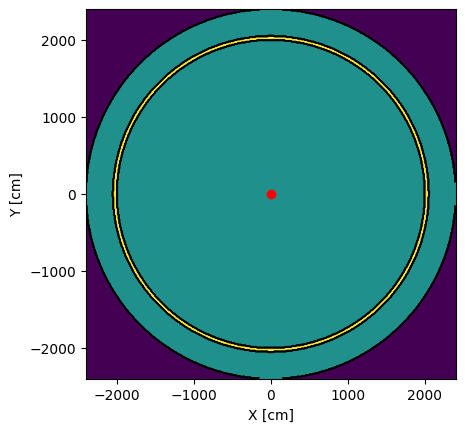

In [7]:
# location of the point source
source_x = 0
source_y = 0
source_z = 1250

xlabel, ylabel = geometry.get_axis_labels(view_direction="z")
plt.xlabel(xlabel)
plt.ylabel(ylabel)

plot_extent = geometry.get_mpl_plot_extent(view_direction="z")

data_slice = geometry.get_slice_of_material_ids(view_direction="z")
# plots the materials with randomly assigned colors
plt.imshow(
    np.fliplr(data_slice),
    extent=plot_extent,
)

# plots the outline of the cells
plt.contour(
    np.fliplr(data_slice),
    origin="upper",
    colors="k",
    linestyles="solid",
    linewidths=1,
    extent=plot_extent,
)

# plots the source location
plt.scatter(source_x, source_y, c="red")
plt.savefig('geometry_view.svg')


/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another PlotBase instance already exists with id=42.
  warn(msg, IDWarning)


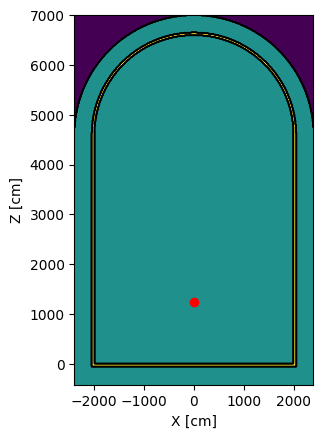

In [8]:
plt.clf()
plt.cla()

xlabel, ylabel = geometry.get_axis_labels(view_direction="y")
plt.xlabel(xlabel)
plt.ylabel(ylabel)

plot_extent = geometry.get_mpl_plot_extent(view_direction="y")

data_slice = geometry.get_slice_of_material_ids(view_direction="y")
# plots the materials with randomly assigned colors
plt.imshow(
    np.fliplr(data_slice),
    extent=plot_extent,
)
# plots the outline of the cells
plt.contour(
    np.fliplr(data_slice),
    origin="upper",
    colors="k",
    linestyles="solid",
    linewidths=1,  
    extent=plot_extent,
)

# plots the source location
plt.scatter(source_x, source_z, c="red")
plt.savefig('geometry_view_2.svg')


In [9]:
energy_bins_n, dose_coeffs_n = openmc.data.dose_coefficients(
    particle='neutron',
    geometry='AP'  # AP defines the direction of the source to person, for more details see documentation https://docs.openmc.org/en/stable/pythonapi/generated/openmc.data.dose_coefficients.html
)

energy_bins_p, dose_coeffs_p = openmc.data.dose_coefficients(particle='photon', geometry='AP')
energy_function_filter_n = openmc.EnergyFunctionFilter(energy_bins_n, dose_coeffs_n)

energy_function_filter_n.interpolation = 'cubic'  # cubic interpolation is recommended by ICRP

energy_function_filter_p = openmc.EnergyFunctionFilter(energy_bins_p, dose_coeffs_p)
energy_function_filter_p.interpolation = 'cubic'  # cubic interpolation is recommended by ICRP

neutron_particle_filter = openmc.ParticleFilter(["neutron"])
photon_particle_filter = openmc.ParticleFilter(["photon"])
surface_filter = openmc.CellFilter(boundary_mid_cell)

dose_tally_n = openmc.Tally(name="dose_tally_on_surface_n")
dose_tally_n.scores = ["current"]
dose_tally_n.filters = [
    surface_filter,
    neutron_particle_filter,
    energy_function_filter_n,
]


mesh = openmc.RegularMesh().from_domain(geometry)
mesh.dimension = (100, 100, 1)

mesh_filter = openmc.MeshFilter(mesh)

flux_tally = openmc.Tally(name="flux tally")
flux_tally.filters = [mesh_filter]
flux_tally.scores = ["flux"]

energy_filter = openmc.EnergyFilter(np.linspace(0, 3e6, 1000))

cell_filter = openmc.CellFilter(boundary_mid_cell)
surface_spectra_tally = openmc.Tally(name='surface_spectra_tally')
surface_spectra_tally.scores = ['flux']
particle_filter = openmc.ParticleFilter(["neutron"])
surface_spectra_tally.filters = [cell_filter, particle_filter, energy_filter]

my_tallies = openmc.Tallies([dose_tally_n, flux_tally, surface_spectra_tally])

In [10]:
space = openmc.stats.Point((source_x, source_y, source_z))
angle = openmc.stats.Isotropic()
particle = openmc.stats.Particle = "neutron"
energy = openmc.stats.muir(e0=2e+6,m_rat=5.0, kt=20000.0)


source = openmc.Source(space=space, angle=angle, energy=energy, particle=particle)
settings_file = openmc.Settings()
settings_file.batches = 5
settings_file.inactive = 0
settings_file.particles = 50000
settings_file.run_mode = "fixed source"
settings_file.source = source

settings_file.export_to_xml()

/opt/venv/lib/python3.11/site-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


In [11]:
model = openmc.model.Model(geometry, materials, settings_file, my_tallies)
!rm *.h5
sp_filename = model.run()

/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=5.
  warn(msg, IDWarning)
/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=4.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [12]:
import math

# open the results file
sp = openmc.StatePoint(sp_filename)

# access the tally using pandas dataframes
tally_result = sp.get_tally(name='dose_tally_on_surface_n').mean.flatten()[0]

reactor_power = 69e6  # in units of watts
energy_of_each_fusion_reaction = 192.9e6 * 2.8e-18  # eV converted to Joules
neutrons_per_second = 2*(reactor_power / energy_of_each_fusion_reaction)# units of neutrons per second

volume_of_cell = 1.95e10
# tally.mean is in units of pSv-cm3/source neutron
# this multiplication changes units to neutron to pSv-cm3/second
total_dose = tally_result * neutrons_per_second

# converts from pSv-cm3/second to pSv/second
total_dose = total_dose / volume_of_cell

# converts from (pico) pSv/second to (milli) mSv/second
total_dose = total_dose * 1e-9

total_dose = total_dose * 60 * 60
# print results
print('The surface dose = ', total_dose, 'milli Sv per hr')

The surface dose =  0.0 milli Sv per hr


/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/opt/venv/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another PlotBase instance already exists with id=42.
  warn(msg, IDWarning)


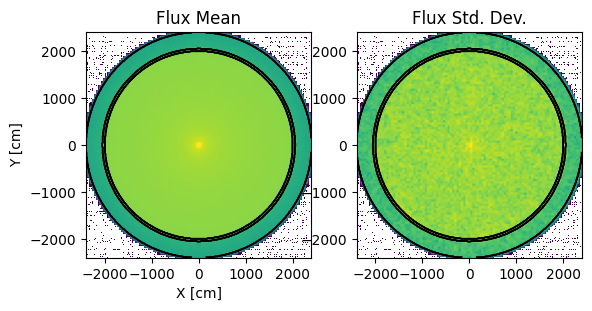

In [13]:

flux_tally = sp.get_tally(name="flux tally")

llc, urc = model.geometry.bounding_box

flux_mean = flux_tally.mean.reshape(100, 100)
plt.subplot(1, 2, 1)
plt.imshow(
    flux_mean,
    origin="lower",
    extent=(llc[0], urc[0], llc[1], urc[1]),
    norm=LogNorm(),
    )
plt.title("Flux Mean")

plot_extent = geometry.get_mpl_plot_extent(view_direction="z")
data_slice = geometry.get_slice_of_material_ids(view_direction="z")
xlabel, ylabel = geometry.get_axis_labels(view_direction="z")
plt.xlabel(xlabel)
plt.ylabel(ylabel)

plt.contour(
    np.fliplr(data_slice),
    origin="upper",
    colors="k",
    linestyles="solid",
    linewidths=1,
    extent=plot_extent,
    )

plt.subplot(1, 2, 2)
# # create a plot of the flux relative error
flux_std_dev = flux_tally.get_values(value="std_dev").reshape(*mesh.dimension)
plt.imshow(
    flux_std_dev,
    origin="lower",
    extent=(llc[0], urc[0], llc[1], urc[1]),
    norm=LogNorm(),
    )
plt.title("Flux Std. Dev.")

plt.xlabel(None)
plt.ylabel(None)
plt.contour(
    np.fliplr(data_slice),
    origin="upper",
    colors="k",
    linestyles="solid",
    linewidths=1,
    extent=plot_extent,
    )
#plt.savefig("contour_neutron_33")

/tmp/ipykernel_918/3084930665.py:16: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


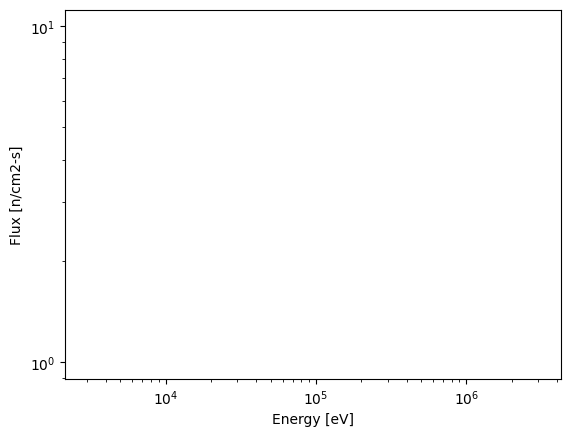

In [14]:
cell_tally = sp.get_tally(name='surface_spectra_tally')

openmc_flux = cell_tally.mean.flatten()

volume_of_cell = 1.95e10 # in units of cm3
reactor_power = 69e6  # in units of watts
energy_of_each_fusion_reaction = 192.9e6 * 2.8e-18  # eV converted to Joules
neutrons_per_second = reactor_power / energy_of_each_fusion_reaction

flux = (openmc_flux / volume_of_cell) * neutrons_per_second # divide by cell volume and then multiply by source strength

plt.figure()
 # trim the last energy filter bin edge to make the number of x and y values the same
plt.step(energy_filter.values[:-1], flux)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Flux [n/cm2-s]')
plt.xlabel('Energy [eV]')
plt.show()

/opt/venv/lib/python3.11/site-packages/openmc/filter.py:1411: RuntimeWarning: divide by zero encountered in divide
  return np.log10(self.bins[:, 1]/self.bins[:, 0])
/tmp/ipykernel_918/1396015303.py:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


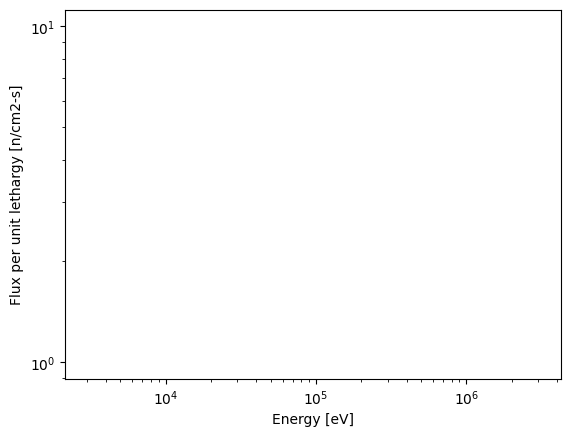

In [15]:
bin_boundaries = energy_filter.lethargy_bin_width
norm_flux = flux / bin_boundaries

plt.figure()
 # trim the last energy filter bin edge to make the number of x and y values the same
plt.step(energy_filter.values[:-1], norm_flux)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Flux per unit lethargy [n/cm2-s]')
plt.xlabel('Energy [eV]')
plt.show()

In [16]:
energy_bins = np.linspace(0, 3e6, 1000)

energy_bin_centers = energy_bins[1:] + 0.5 * (energy_bins[1] - energy_bins[0])

E, a, b, c = 2000_000, 1000, 4, 0.0002
number_broadening_samples = 1e6

def gauss(E=E, a=a, b=b, c=c):
    sigma = (a + b * (E + c * E**2)**0.5) / (2 * (2 * np.log(2))**0.5)
    return np.random.normal(loc=E, scale=sigma)

samples = np.random.choice(energy_bin_centers[1:], size=int(number_broadening_samples), p=norm_flux[1:]/np.sum(norm_flux[1:]))
broaded_pulse_height_values = gauss(samples)

broaded_spectrum, _ = np.histogram(broaded_pulse_height_values, bins=energy_bins)
renormalized_broaded_spectrum = broaded_spectrum / np.sum(broaded_spectrum) * np.sum(norm_flux[1:])

/tmp/ipykernel_918/891250860.py:12: RuntimeWarning: divide by zero encountered in divide
  samples = np.random.choice(energy_bin_centers[1:], size=int(number_broadening_samples), p=norm_flux[1:]/np.sum(norm_flux[1:]))
/tmp/ipykernel_918/891250860.py:12: RuntimeWarning: invalid value encountered in divide
  samples = np.random.choice(energy_bin_centers[1:], size=int(number_broadening_samples), p=norm_flux[1:]/np.sum(norm_flux[1:]))


ValueError: probabilities contain NaN

In [ ]:
plt.figure()

plt.semilogy(energy_bin_centers[1:], renormalized_broaded_spectrum[1:], label="Response")

plt.legend()
plt.xlabel('Energy [eV]')
plt.ylabel('Flux per unit lethargy [n/cm2-s]')
plt.title('Pulse Height Values')
plt.grid(True)
plt.tight_layout()

In [ ]:
import pandas as pd

# Convert the array to a DataFrame
df = pd.DataFrame(renormalized_broaded_spectrum, columns=['Values'])

df.to_csv('neutron_broaded_spectrum_56l.csv', index=False)